In [15]:
# Importing all necessary libraries

import os
import numpy as np
import librosa
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt
import soundfile as sf
from tensorflow.keras.layers import Conv1D, GRU, Dense, Dropout, Flatten, Input, Attention, Bidirectional, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [16]:
# Path to dataset
mypath = r"C:\Users\chatt\Desktop\Project\KAUH Dataset\Audio Files"
filenames = [f for f in os.listdir(mypath) if f.endswith('.wav')]
filepaths = [os.path.join(mypath, f) for f in filenames]

# Feature Extraction Function
def extract_features(file_path, sr=22050):
    try:
        audio, _ = librosa.load(file_path, sr=sr)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        return np.mean(mfcc.T, axis=0)
    except Exception as e:
        print(f"Error in feature extraction: {e}")
        return None

# Data Preparation
X, y = [], []
for file in filepaths:
    feature = extract_features(file)
    if feature is not None:
        X.append(feature)
        y.append("Asthma" if "Asthma" in file else "COPD")  # Adjust label extraction as needed

X = np.array(X)
y = LabelEncoder().fit_transform(y)
X = StandardScaler().fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

KeyboardInterrupt: 

In [ ]:
# Define 1D CNN Model
def build_1dcnn(input_shape):
    model = Sequential([
        Conv1D(128, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv1D(128, kernel_size=3, activation='relu', padding='same'),
        Dropout(0.3),

        Conv1D(256, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        Conv1D(256, kernel_size=3, activation='relu', padding='same'),
        Dropout(0.4),

        Conv1D(512, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        Conv1D(512, kernel_size=3, activation='relu', padding='same'),
        Dropout(0.5),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    return model

# Select and Compile a Model (Example: 1D CNN)
model = build_1dcnn((X_train.shape[1], 1))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()




c:\Users\chatt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 40, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 40, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 40, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 40, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 40, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 40, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 40, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 40, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 40, 512)        │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 40, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 40, 512)        │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 40, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 20480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │    10,486,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,188,289 (46.49 MB)

 Trainable params: 12,186,497 (46.49 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [ ]:
# Train Model for 1D CNN
X_train_reshaped = np.expand_dims(X_train, axis=-1)
X_test_reshaped = np.expand_dims(X_test, axis=-1)
history = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=16, validation_data=(X_test_reshaped, y_test))

# Evaluate
loss, acc = model.evaluate(X_test_reshaped, y_test)
print(f"Test Accuracy for 1D-CNN: {acc * 100:.2f}%")

# Retrieve training and validation accuracy
history_dict = history.history  

train_acc = history_dict['accuracy'][-1]  # Last training accuracy
val_acc = history_dict['val_accuracy'][-1]  # Last validation accuracy

print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")


model.save("audio_classifier.h5")

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8303 - loss: 0.5459 - val_accuracy: 0.8416 - val_loss: 0.4766
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8294 - loss: 0.4898 - val_accuracy: 0.8416 - val_loss: 0.4925
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8254 - loss: 0.5128 - val_accuracy: 0.8416 - val_loss: 0.4845
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8324 - loss: 0.5166 - val_accuracy: 0.8416 - val_loss: 0.4903
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8670 - loss: 0.4093 - val_accuracy: 0.8416 - val_loss: 0.5142
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8079 - loss: 0.5037 - val_accuracy: 0.8416 - val_loss: 0.5124
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8369 - loss: 0.4396 - val_accuracy: 0.8416 - val_loss: 0.5283
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8325 - loss: 0.4643 - val_accuracy: 0.8416 - v

Test Accuracy for 1D-CNN: 84.16%
Training Accuracy: 83.83%
Validation Accuracy: 84.16%


Graph plotting for 1D-CNN

✅ Final Training Accuracy: 92.34%
✅ Final Validation Accuracy: 46.53%
✅ Final Training Loss: 0.2322
✅ Final Validation Loss: 1.1244


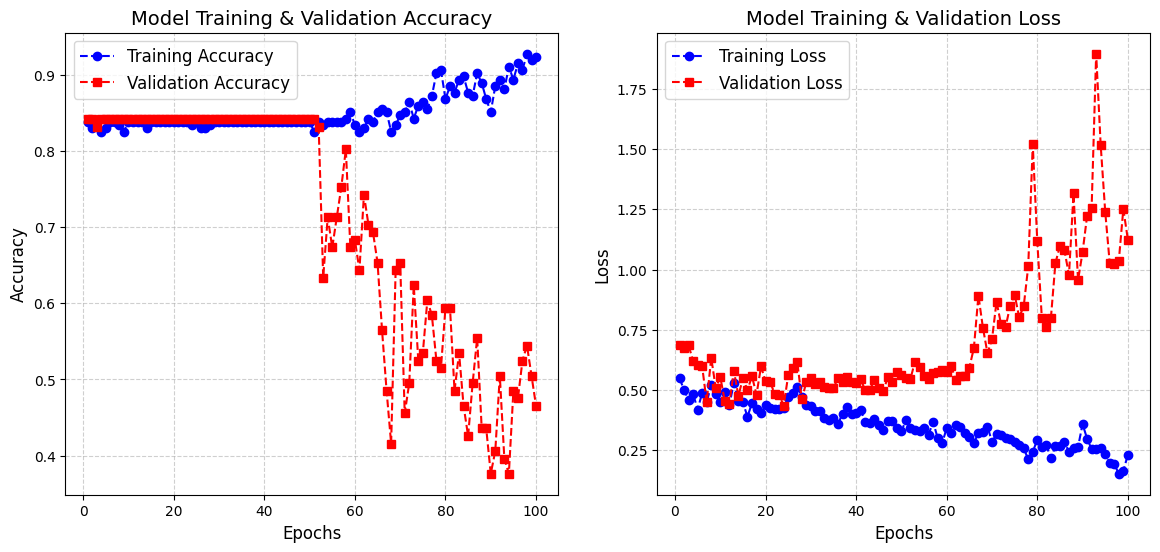

In [21]:
import matplotlib.pyplot as plt

# ✅ Extract Training History
train_acc = history.history.get('accuracy', [])
val_acc = history.history.get('val_accuracy', [])
train_loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])
epochs = range(1, len(train_acc) + 1)

if train_acc and val_acc and train_loss and val_loss:
    # ✅ Print Final Accuracy & Loss
    print(f"✅ Final Training Accuracy: {train_acc[-1] * 100:.2f}%")
    print(f"✅ Final Validation Accuracy: {val_acc[-1] * 100:.2f}%")
    print(f"✅ Final Training Loss: {train_loss[-1]:.4f}")
    print(f"✅ Final Validation Loss: {val_loss[-1]:.4f}")

    # ✅ Plot Accuracy
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Training Accuracy', color='blue', linestyle='dashed', marker='o', markersize=6)
    plt.plot(epochs, val_acc, label='Validation Accuracy', color='red', linestyle='dashed', marker='s', markersize=6)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.title("Model Training & Validation Accuracy", fontsize=14)

    # ✅ Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Training Loss', color='blue', linestyle='dashed', marker='o', markersize=6)
    plt.plot(epochs, val_loss, label='Validation Loss', color='red', linestyle='dashed', marker='s', markersize=6)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.title("Model Training & Validation Loss", fontsize=14)


    # ✅ Save & Show Plot
    plt.savefig("Training_Validation_Accuracy_Loss100epoch.png", dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("⚠️ No training history found. Ensure the model was trained correctly.")


In [19]:
# Define Bi-GRU Model
def build_bi_gru(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        
        Bidirectional(GRU(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
        BatchNormalization(),
        Bidirectional(GRU(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
        Dropout(0.4),

        Bidirectional(GRU(256, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)),
        BatchNormalization(),
        Bidirectional(GRU(256, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)),
        Dropout(0.5),

        Bidirectional(GRU(512, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)),
        BatchNormalization(),
        Bidirectional(GRU(512, dropout=0.5, recurrent_dropout=0.5)),
        Dropout(0.6),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

# Select and Compile a Model 
model = build_bi_gru((X_train.shape[1], 1))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_22                │ (None, 40, 256)        │       100,608 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 40, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_23                │ (None, 40, 256)        │       296,448 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 40, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_24                │ (None, 40, 512)        │       789,504 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 40, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_25                │ (None, 40, 512)        │     1,182,720 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 40, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_26                │ (None, 40, 1024)       │     3,151,872 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 40, 1024)       │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_27                │ (None, 1024)           │     4,724,736 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 10,950,401 (41.77 MB)

 Trainable params: 10,946,817 (41.76 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [13]:
# Define Bi-GRU Model
def build_bi_gru(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        
        Bidirectional(GRU(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
        BatchNormalization(),
        Bidirectional(GRU(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
        Dropout(0.4),

        Bidirectional(GRU(256, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)),
        BatchNormalization(),
        Bidirectional(GRU(256, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)),
        Dropout(0.5),

        Bidirectional(GRU(512, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)),
        BatchNormalization(),
        Bidirectional(GRU(512, dropout=0.5, recurrent_dropout=0.5)),
        Dropout(0.6),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

model.summary

# Select and Compile a Model 
model = build_bi_gru((X_train.shape[1], 1))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train Model
X_train_reshaped = np.expand_dims(X_train, axis=-1)
X_test_reshaped = np.expand_dims(X_test, axis=-1)
history = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=16, validation_data=(X_test_reshaped, y_test))

# Evaluate
loss, acc = model.evaluate(X_test_reshaped, y_test)
print(f"Test Accuracy for Bi-GRU: {acc * 100:.2f}%")

# Retrieve training and validation accuracy
history_dict = history.history 

train_acc = history_dict['accuracy'][-1]  
val_acc = history_dict['val_accuracy'][-1]  

print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")


Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7405 - loss: 0.6358 - val_accuracy: 0.8416 - val_loss: 0.6502
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8281 - loss: 0.4900 - val_accuracy: 0.8416 - val_loss: 0.6244
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8299 - loss: 0.4704 - val_accuracy: 0.8416 - val_loss: 0.5698
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8276 - loss: 0.4787 - val_accuracy: 0.8416 - val_loss: 0.5406
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8379 - loss: 0.4589 - val_accuracy: 0.8416 - val_loss: 0.5220
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8499 - loss: 0.4546 - val_accuracy: 0.8416 - val_loss: 0.5111
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8258 - loss: 0.4948 - val_accuracy: 0.8416 - val_loss: 0.5186
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8448 - loss: 0.4061 - val_accuracy: 0.8416 - v

In [20]:
# 1D CNN + Bi-GRU + Attention
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        scores = tf.nn.softmax(inputs, axis=1)
        return inputs * scores

def build_cnn_bi_gru_attention(input_shape):
    inputs = Input(shape=input_shape)

    # CNN Feature Extractor
    x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Bi-GRU for Sequence Learning
    x = Bidirectional(GRU(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(x)
    x = BatchNormalization()(x)
    x = Bidirectional(GRU(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(x)
    x = Dropout(0.4)(x)

    x = Bidirectional(GRU(512, return_sequences=True, dropout=0.4, recurrent_dropout=0.4))(x)
    x = BatchNormalization()(x)
    x = Bidirectional(GRU(512, return_sequences=True, dropout=0.4, recurrent_dropout=0.4))(x)
    x = Dropout(0.5)(x)

    # Attention Mechanism
    x = AttentionLayer()(x)

    # Fully Connected Layers
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_22                │ (None, 40, 256)        │       100,608 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 40, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_23                │ (None, 40, 256)        │       296,448 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 40, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_24                │ (None, 40, 512)        │       789,504 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 40, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_25                │ (None, 40, 512)        │     1,182,720 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 40, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_26                │ (None, 40, 1024)       │     3,151,872 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 40, 1024)       │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_27                │ (None, 1024)           │     4,724,736 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 10,950,401 (41.77 MB)

 Trainable params: 10,946,817 (41.76 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [14]:
# 1D CNN + Bi-GRU + Attention
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        scores = tf.nn.softmax(inputs, axis=1)
        return inputs * scores

def build_cnn_bi_gru_attention(input_shape):
    inputs = Input(shape=input_shape)

    # CNN Feature Extractor
    x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Bi-GRU for Sequence Learning
    x = Bidirectional(GRU(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(x)
    x = BatchNormalization()(x)
    x = Bidirectional(GRU(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(x)
    x = Dropout(0.4)(x)

    x = Bidirectional(GRU(512, return_sequences=True, dropout=0.4, recurrent_dropout=0.4))(x)
    x = BatchNormalization()(x)
    x = Bidirectional(GRU(512, return_sequences=True, dropout=0.4, recurrent_dropout=0.4))(x)
    x = Dropout(0.5)(x)

    # Attention Mechanism
    x = AttentionLayer()(x)

    # Fully Connected Layers
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

model.summary

# Select and Compile a Model 
model = build_cnn_bi_gru_attention((X_train.shape[1], 1))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train Model
X_train_reshaped = np.expand_dims(X_train, axis=-1)
X_test_reshaped = np.expand_dims(X_test, axis=-1)
history = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=16, validation_data=(X_test_reshaped, y_test))

# Evaluate
loss, acc = model.evaluate(X_test_reshaped, y_test)
print(f"Test Accuracy for CNN_BiGRU_Attention: {acc * 100:.2f}%")

# Retrieve training and validation accuracy
history_dict = history.history  

train_acc = history_dict['accuracy'][-1]  # Last training accuracy
val_acc = history_dict['val_accuracy'][-1]  # Last validation accuracy

print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")


Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8221 - loss: 0.6128 - val_accuracy: 0.8416 - val_loss: 0.6859
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7988 - loss: 0.5675 - val_accuracy: 0.8416 - val_loss: 0.6744
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8630 - loss: 0.3994 - val_accuracy: 0.8317 - val_loss: 0.6853
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8236 - loss: 0.4742 - val_accuracy: 0.8416 - val_loss: 0.6212
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8301 - loss: 0.4236 - val_accuracy: 0.8416 - val_loss: 0.6043
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8513 - loss: 0.4558 - val_accuracy: 0.8416 - val_loss: 0.5987
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7825 - loss: 0.4897 - val_accuracy: 0.8416 - val_loss: 0.4495
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8700 - loss: 0.4295 - val_accuracy: 0.8416 - v